In [30]:
from itertools import product
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

### Notes:
- Based on boxplots it seems that big jump from 2020 to 2021 and 2022 seasons
- Starting in 2021, the number of athletes recorded is 50 instead of 75 (maybe we should only keep top 50 for consistency in other years)
- 2020 may be a transition year for supershoes, could throw it out because they are not fully adopted, plus covid/masking while running makes it a weird year.
- Here I assign ordinal values to class year, but maybe we should use dummy vars instead. Same for yearOrdinal
 

In [31]:
events = ["mile", "3000m", "5000m"]
gender = ["f", "m"]
years = list(np.arange(2016, 2023, 1))

combinations = list(product(events, gender, years))

# preprocess and concatenate data from all genders, events, and years
for event, gender, year in combinations:
    temp = pd.read_csv(f"data/{year}_{year+1}_{event}_{gender}.csv")
    
    # temp = temp[temp["Rank"] <= 50] # uncomment to only include top 50 times
    
    # one-hot encode gender
    temp["gender"] = 0 if gender == "f" else 1

    # infer whether supershoes were worn based on year
    # (Nike Dragonfly released in Aug 2020)
    temp["supershoes"] = 1 if year >= 2021 else 0

    # maintain ordinal value for year (may need to scale later)
    temp["year"] = int(year)
    temp["yearOrdinal"] = int(year-2015)

    # add event column
    temp["event"] = event

    if year == 2016 and gender == "f" and event == "mile":
        data = temp
    else:
        data = pd.concat([data, temp], sort=False)

# Assign ordinal values to class year?
# fill NAN values with another class. 5 = other. 
# Typically this happens because of a redshirt season or later injury
# only happens for 6 people in whole dataset
data = data.rename(columns={"Year": "ClassYear"})
data["ClassYear"] = data["ClassYear"].str[0:2].map({"FR": 1, "SO": 2, "JR": 3, "SR": 4})
data["ClassYear"] = data["ClassYear"].fillna(5)

data["dummy"] = data["event"]
# add dummy variables for event
data = pd.get_dummies(data, columns=["dummy"])

In [32]:
data.describe()

,Rank,ClassYear,Time_seconds,gender,supershoes,year,yearOrdinal
count,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000
mean,25.504757,2.922455,552.577517,0.500000,0.285442,2018.999524,3.999524
std,14.437468,1.020112,263.870985,0.500119,0.451732,2.000119,2.000119
min,1.000000,1.000000,230.390000,0.000000,0.000000,2016.000000,1.000000
25%,13.000000,2.000000,276.892500,0.000000,0.000000,2017.000000,2.000000
50%,26.000000,3.000000,499.445000,0.500000,0.000000,2019.000000,4.000000
75%,38.000000,4.000000,824.605000,1.000000,1.000000,2021.000000,6.000000
max,50.000000,5.000000,990.230000,1.000000,1.000000,2022.000000,7.000000


In [33]:
data.head()

,Rank,Athlete,ClassYear,Team,Time,Meet,Meet_Date,Time_seconds,gender,supershoes,year,yearOrdinal,event,dummy_3000m,dummy_5000m,dummy_mile
0,1,"Edwards, Kaela",4.0,Oklahoma State,4:28.75,110th NYRR Millrose Games,"Feb 11, 2017",268.75,0,0,2016,1,mile,False,False,True
1,2,"Purrier, Elinor",3.0,New Hampshire,4:29.44,110th NYRR Millrose Games,"Feb 11, 2017",269.44,0,0,2016,1,mile,False,False,True
2,3,"Rivers, Danae",1.0,Penn State,4:32.55,2017 Husky Classic,"Feb 10, 2017",272.55,0,0,2016,1,mile,False,False,True
3,4,"Jones, Dani",2.0,Colorado,4:32.68\n@,Colorado Open,"Feb 2, 2017",272.68,0,0,2016,1,mile,False,False,True
4,5,"Cleirigh Buttner, Siofra",3.0,Villanova,4:33.16,Fastrack National Invite,"Feb 10, 2017",273.16,0,0,2016,1,mile,False,False,True


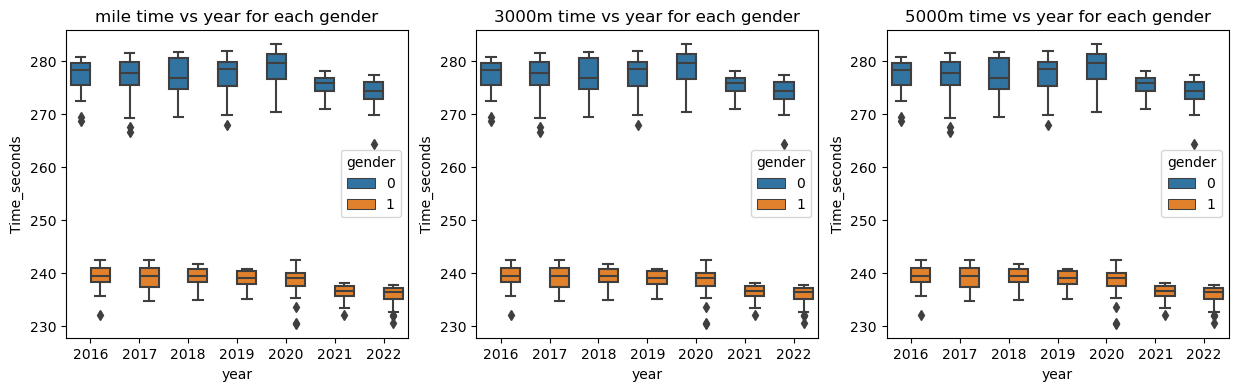

In [34]:
# Make boxplots for each year/gender and event
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for event, ax in zip(events, axs):
    temp = data[(data["event"] == "mile")]
    sns.boxplot(x="year", y="Time_seconds", ax=ax, data=temp, hue="gender").set(
        title=f"{event} time vs year for each gender"
    )

In [35]:
# helper function to build eqn string and save supershoe coefficients
def build_eqn(model, cols, supershoe_coefs=[]):
    eqn = f"{np.round(model.intercept_, 3)} + "
    for coef, col in zip(model.coef_, cols):
        if col == "supershoes": supershoe_coefs.append(coef)
        eqn += f"({np.round(coef, 3)})*{col} + "
    return eqn[:-2], supershoe_coefs

# Linear Regression
# only fit on relevant columns for x data
print(f"Linear fit results for all predictors:")
temp = data
x_cols = [
    "dummy_5000m",
    "dummy_3000m",
    "dummy_mile", 
    "gender",
    "supershoes",
    "yearOrdinal",
    "Rank",
    "ClassYear",
]
x = temp[x_cols]
y = temp["Time_seconds"]
# create linear regression model
model = LinearRegression().fit(x, y)
print(f"R^2: {model.score(x, y)}")
eqn, _ = build_eqn(model, x_cols)
print(f"Equation: Time_seconds = {eqn}")

Linear fit results for all predictors:
R^2: 0.9943469859752099
Equation: Time_seconds = 585.833 + (337.387)*dummy_5000m + (-42.295)*dummy_3000m + (-295.092)*dummy_mile + (-81.056)*gender + (-9.718)*supershoes + (0.202)*yearOrdinal + (0.44)*Rank + (-0.669)*ClassYear 


In [36]:

# Now we split out the data by event and fit a linear 
# regression model for each event separately
supershoe_coefs = []
for event in events:
    print(f"\nEvent: {event} linear fit results:")
    temp = data[(data["event"] == event)]
    x_cols = [
        "gender",
        "supershoes",
        "yearOrdinal",
        "Rank",
        "ClassYear",
    ]
    x = temp[x_cols]
    y = temp["Time_seconds"]
    # create linear regression model
    model = LinearRegression().fit(x, y)
    print(f"R^2: {model.score(x, y)}")
    eqn, supershoe_coefs = build_eqn(model, x_cols, supershoe_coefs)
    print(f"Equation: Time_seconds = {eqn}")


Event: mile linear fit results:
R^2: 0.9964094693206066
Equation: Time_seconds = 273.642 + (-38.574)*gender + (-3.022)*supershoes + (0.027)*yearOrdinal + (0.158)*Rank + (-0.037)*ClassYear 

Event: 3000m linear fit results:
R^2: 0.9946055094261894
Equation: Time_seconds = 540.228 + (-74.03)*gender + (-8.895)*supershoes + (0.114)*yearOrdinal + (0.382)*Rank + (-0.189)*ClassYear 

Event: 5000m linear fit results:
R^2: 0.9914658939864623
Equation: Time_seconds = 938.126 + (-130.584)*gender + (-16.801)*supershoes + (0.45)*yearOrdinal + (0.791)*Rank + (-0.009)*ClassYear 


Text(0.5, 1.0, 'Supershoe effect for each event')

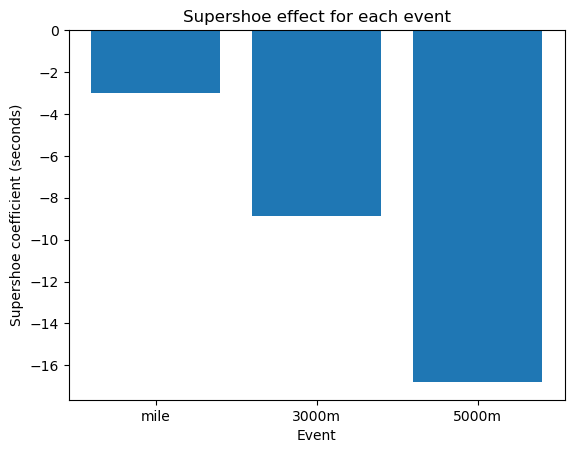

In [37]:
# Plot bar plot of effect as measured by coefficients
plt.bar(events, supershoe_coefs)
plt.ylabel("Supershoe coefficient (seconds)")
plt.xlabel("Event")
plt.title(f"Supershoe effect for each event")


Event: mile linear fit results:
R^2: 0.8679684814312773
Equation for gender 0: Time_seconds = 272.158 + (-3.717)*supershoes + (0.242)*yearOrdinal + (0.195)*Rank + (-0.079)*ClassYear 
R^2: 0.903008062859974
Equation for gender 1: Time_seconds = 236.558 + (-2.329)*supershoes + (-0.188)*yearOrdinal + (0.121)*Rank + (0.005)*ClassYear 

Event: 3000m linear fit results:
R^2: 0.8712144328257989
Equation for gender 0: Time_seconds = 537.467 + (-9.479)*supershoes + (0.221)*yearOrdinal + (0.475)*Rank + (-0.141)*ClassYear 
R^2: 0.928142537589159
Equation for gender 1: Time_seconds = 468.737 + (-8.343)*supershoes + (0.021)*yearOrdinal + (0.29)*Rank + (-0.177)*ClassYear 

Event: 5000m linear fit results:
R^2: 0.8376416285710795
Equation for gender 0: Time_seconds = 928.151 + (-20.279)*supershoes + (2.256)*yearOrdinal + (0.967)*Rank + (-0.261)*ClassYear 
R^2: 0.9670368300979386
Equation for gender 1: Time_seconds = 818.305 + (-13.395)*supershoes + (-1.348)*yearOrdinal + (0.615)*Rank + (-0.024)*Clas

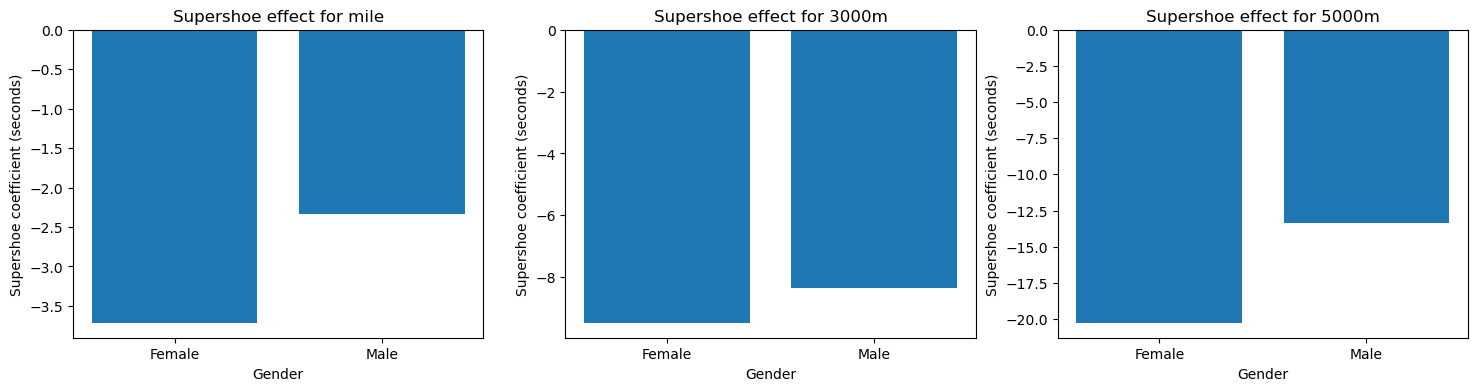

In [38]:
# Here we separate the equations by gender and event to see 
# if there are differences in the effect of supershoes across 
# events or genders
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for event, ax in zip(events, axs):
    print(f"\nEvent: {event} linear fit results:")
    supershoe_coefs = []
    for gender in [0, 1]:
        temp = data[(data["event"] == event) & (data["gender"] == gender)]
        x_cols = [
            "supershoes",
            "yearOrdinal",
            "Rank",
            "ClassYear",
        ]
        x = temp[x_cols]
        y = temp["Time_seconds"]
        # create linear regression model
        model = LinearRegression().fit(x, y)
        print(f"R^2: {model.score(x, y)}")
        eqn, supershoe_coefs = build_eqn(model, x_cols, supershoe_coefs)
        print(f"Equation for gender {gender}: Time_seconds = {eqn}")
    ax.bar(["Female", "Male"], supershoe_coefs)
    ax.set_ylabel("Supershoe coefficient (seconds)")
    ax.set_xlabel("Gender")
    ax.set_title(f"Supershoe effect for {event}")

In [39]:
mile_data = data[data['dummy_mile'] == True ] 
m3000m_data = data[data['dummy_3000m'] == True]
m5000m_data = data[data['dummy_5000m'] == True]

events = [('Mile', mile_data), ('3000m', m3000m_data), ('5000m', m5000m_data)]

In [40]:
# I wanted to look at duplicates of one person
data[['Last Name', 'First Name']] = data['Athlete'].str.split(', ', expand=True)

name_counts = data['Athlete'].value_counts()

print(name_counts)

Athlete
Kemboi, Amon          12
Gregory, Lauren       11
Hasz, Bethany         10
Veatch, Ben            9
Klecker, Joe           9
                      ..
Holland, EJ            1
Lindhorst, Cole        1
Franklin, Baylor       1
Mosavel-Lo, Bashir     1
Kiprop, Victor         1
Name: count, Length: 932, dtype: int64


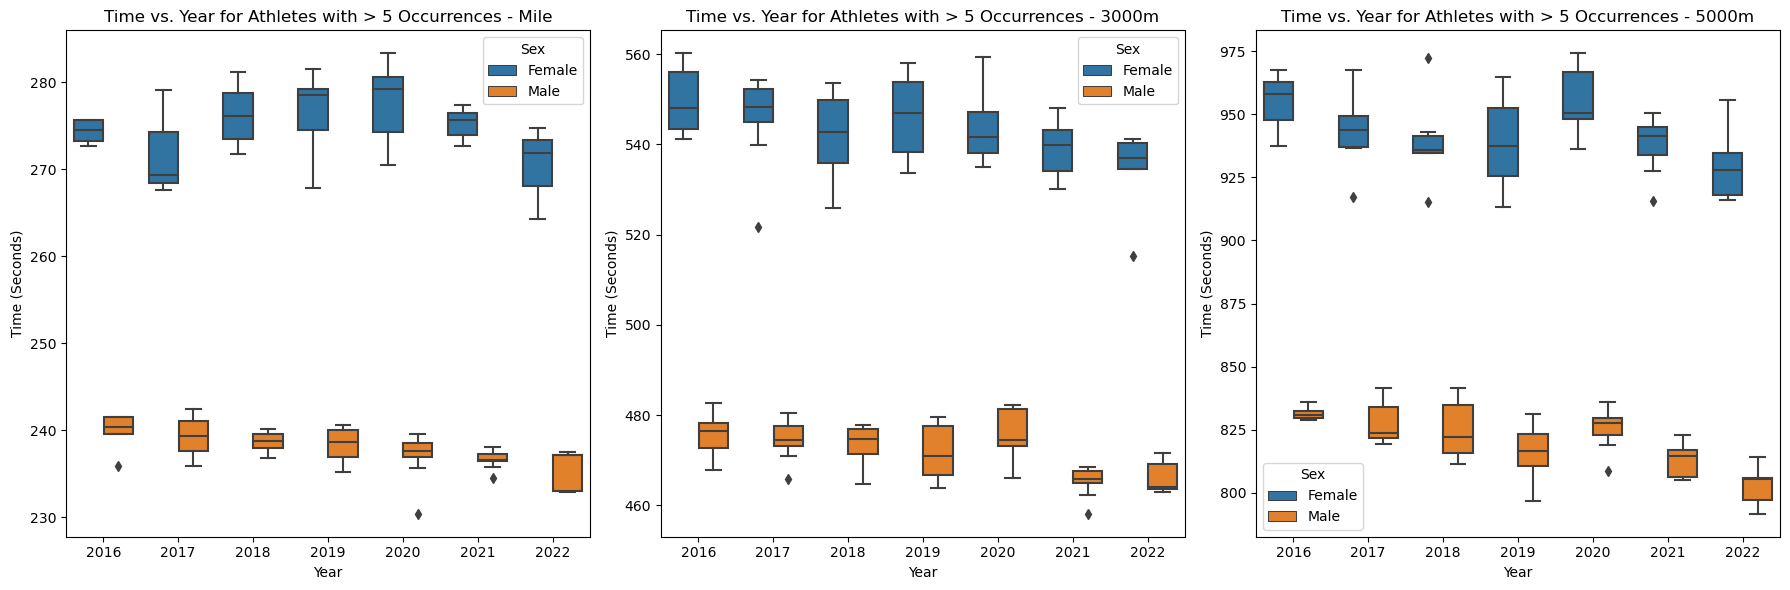

In [41]:
# Filter names with more than 5 occurrences
popular_names = name_counts[name_counts > 5].index
popular_names_data = data[data['Athlete'].isin(popular_names)]

# Define events and corresponding data
mile_data = popular_names_data[popular_names_data['dummy_mile']]
m3000m_data = popular_names_data[popular_names_data['dummy_3000m']]
m5000m_data = popular_names_data[popular_names_data['dummy_5000m']]

events = [('Mile', mile_data), ('3000m', m3000m_data), ('5000m', m5000m_data)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (event, event_data) in zip(axes, events):
    plot = sns.boxplot(data=event_data, x='year', y='Time_seconds', hue='gender', ax=ax)

    plot.set_xlabel('Year')
    plot.set_ylabel('Time (Seconds)')
    plot.set_title(f'Time vs. Year for Athletes with > 5 Occurrences - {event}')
    plot.legend_.texts[1].set_text('Male')
    plot.legend_.texts[0].set_text('Female')
    plot.legend_.set_title('Sex')


plt.tight_layout()
plt.show()

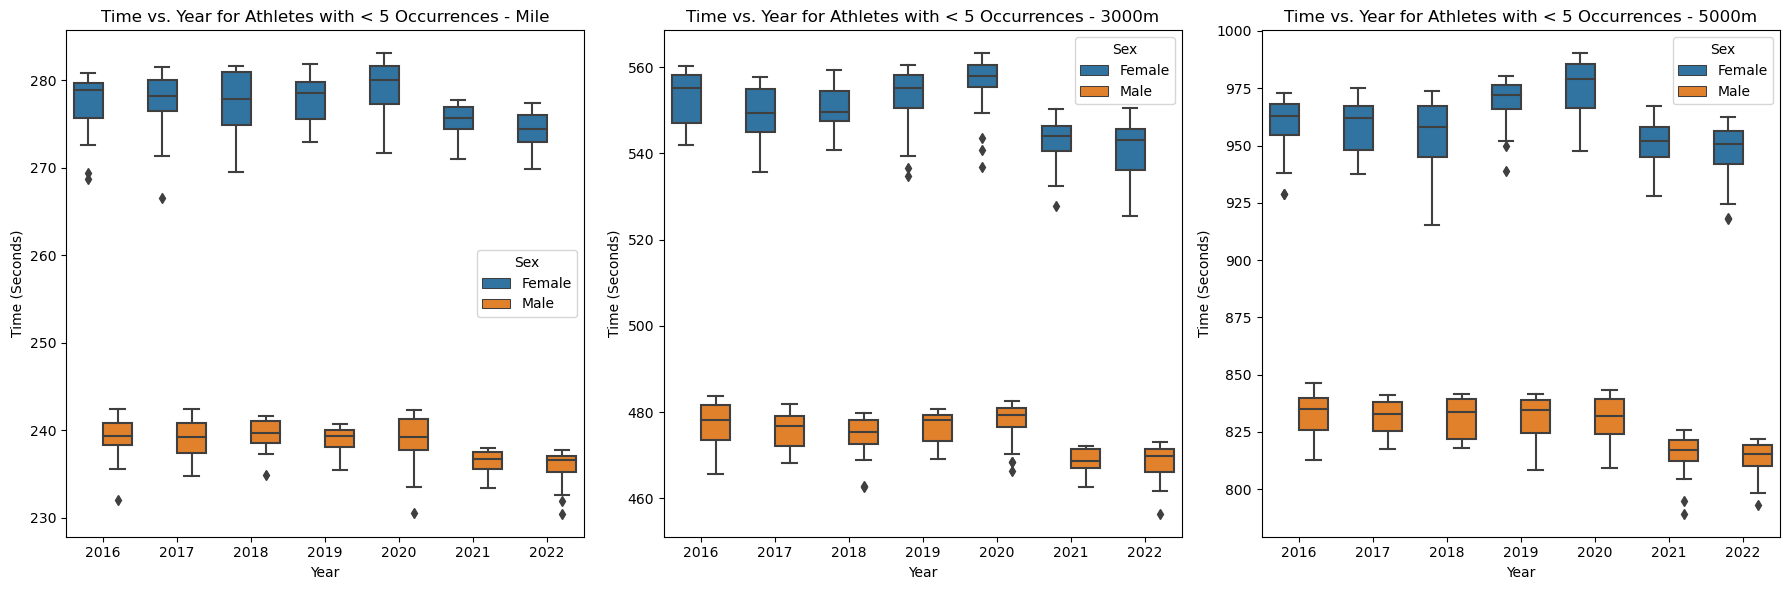

In [42]:
# Filter names with less than 5 occurrences
unpopular_names = name_counts[name_counts < 5].index
unpopular_names_data = data[data['Athlete'].isin(unpopular_names)]

mile_data = unpopular_names_data[unpopular_names_data['dummy_mile']]
m3000m_data = unpopular_names_data[unpopular_names_data['dummy_3000m']]
m5000m_data = unpopular_names_data[unpopular_names_data['dummy_5000m']]

events = [('Mile', mile_data), ('3000m', m3000m_data), ('5000m', m5000m_data)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (event, event_data) in zip(axes, events):
    plot = sns.boxplot(data=event_data, x='year', y='Time_seconds', hue='gender', ax=ax)

    plot.set_xlabel('Year')
    plot.set_ylabel('Time (Seconds)')
    plot.set_title(f'Time vs. Year for Athletes with < 5 Occurrences - {event}')
    plot.legend_.texts[1].set_text('Male')
    plot.legend_.texts[0].set_text('Female')
    plot.legend_.set_title('Sex')


plt.tight_layout()
plt.show()

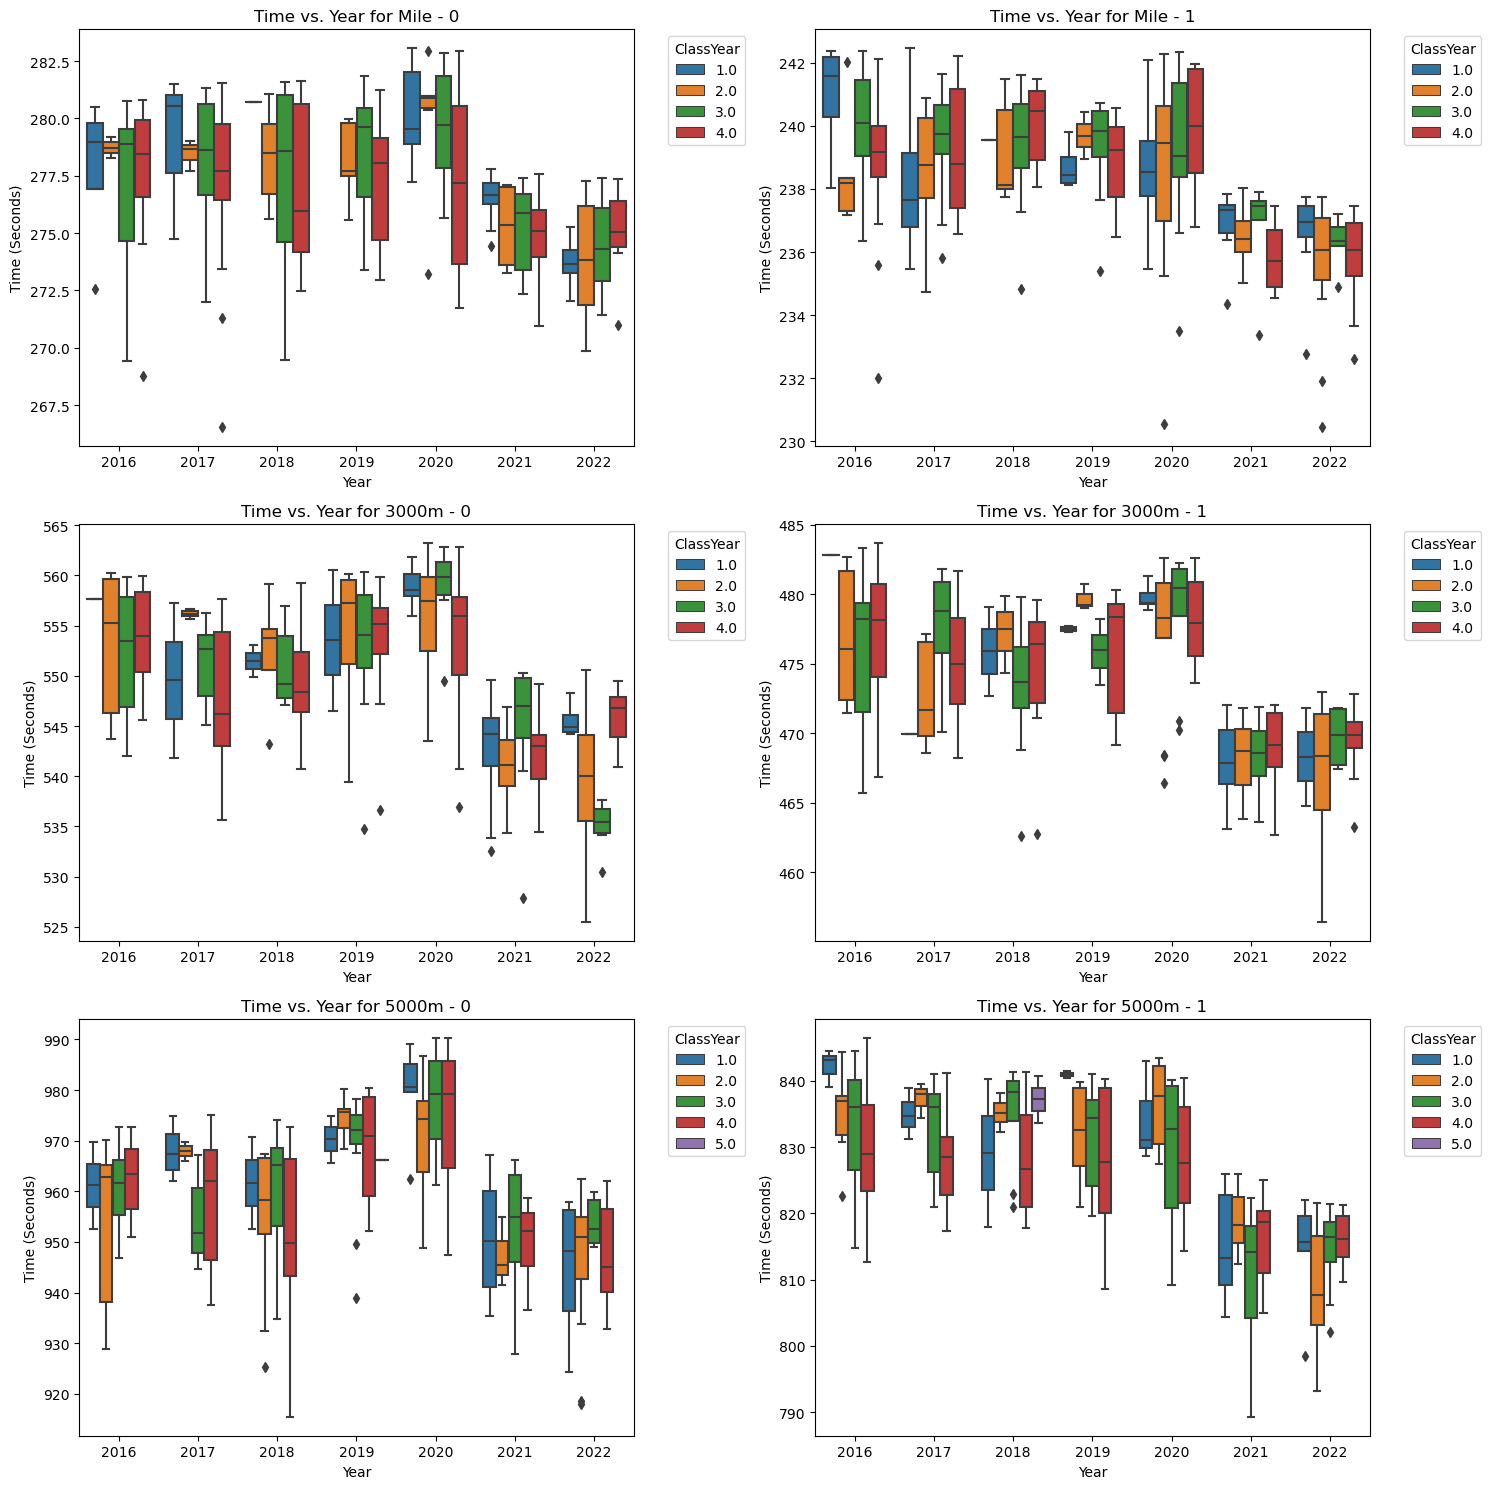

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (event, event_data) in enumerate(events):
    for j, gender in enumerate([0, 1]):
        # Filter data for the current event and gender
        gender_data = event_data[event_data['gender'] == gender]
        

        sns.boxplot(x='year', y='Time_seconds', hue='ClassYear', data=gender_data, ax=axes[i * 2 + j])
        
        axes[i * 2 + j].set_xlabel('Year')
        axes[i * 2 + j].set_ylabel('Time (Seconds)')
        axes[i * 2 + j].set_title(f'Time vs. Year for {event} - {gender}')

        axes[i * 2 + j].legend(title='ClassYear', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

In [44]:
data['thirds'] = [0 if rank <= 16 else 1 if (rank > 16)&(rank<=33) else 2 for rank in data.Rank]

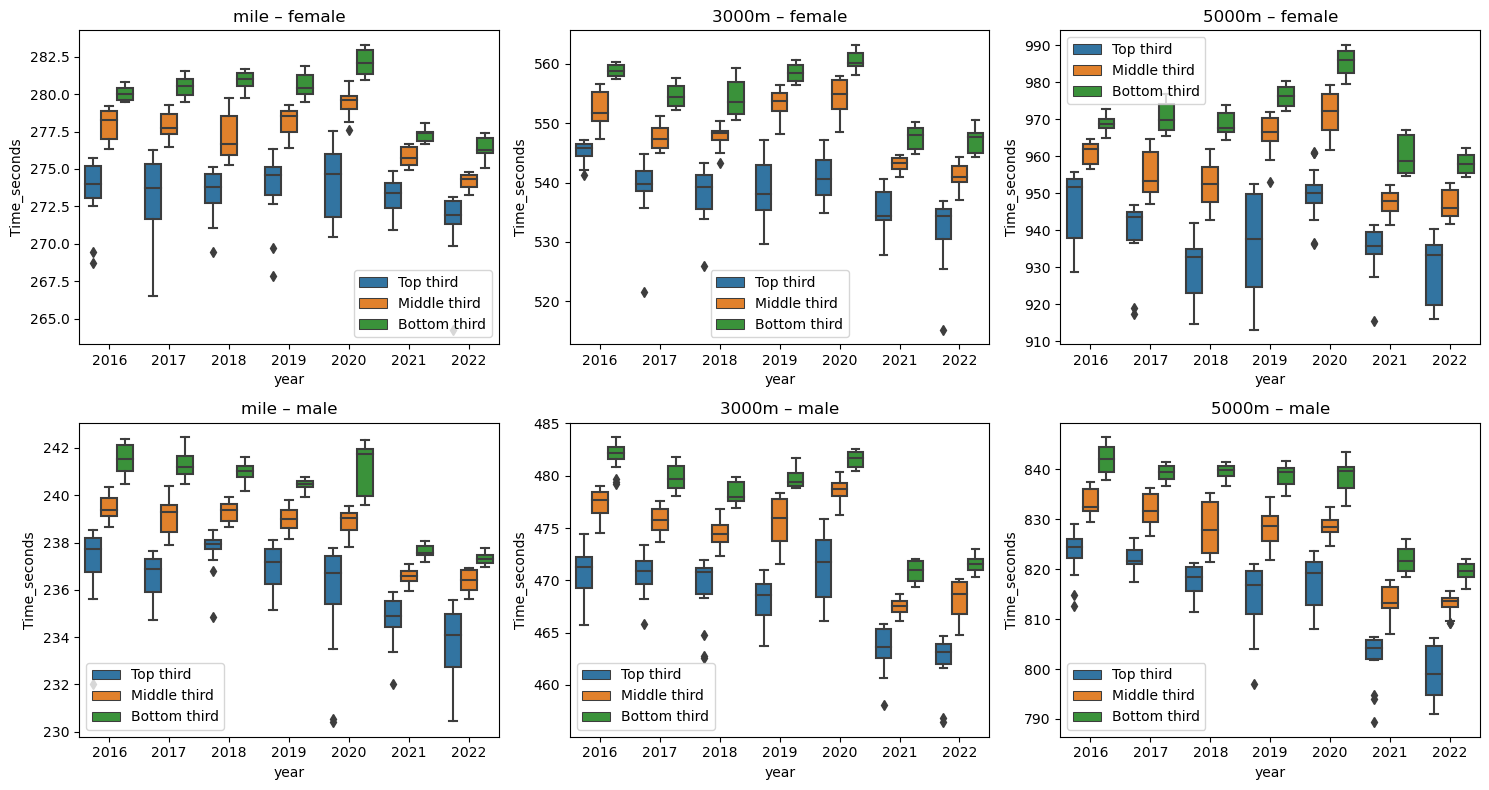

In [45]:
fig, axs = plt.subplots(2,3, figsize=(15,8))
axs = axs.ravel()

for gender in [0,1]:
    for i,event in enumerate(data.event.unique()):
        ax = axs[i+3*gender]
        sns.boxplot(data=data[(data.event==event) & (data.gender==gender)], x='year', y='Time_seconds', hue='thirds', ax=ax)

        if gender==0:
            ax.set_title(event+' – female')
        else:
            ax.set_title(event+' – male')

        ax.legend_.set_title('')
        ax.legend_.texts[0].set_text('Top third')
        ax.legend_.texts[1].set_text('Middle third')
        ax.legend_.texts[2].set_text('Bottom third')

plt.tight_layout()